# M Cycle

## Introduction
  * Market Cycle Analysis and Trade Strategy


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
from io import StringIO
from IntrinioApiCredentials import *
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
%matplotlib inline

In [3]:
# Paramters

ticker = "^GSPC"  #  ^GSPC  Yahoo S&P ... SPX Intrinio S&P ... AAPL ...  
source='file' # ... doesn't matter
dataStartDate=dt.datetime(1950,1,1)  # 1990-01-01 ^GSPC Yahoo ... 2007-01-01 Intrinio
today = dt.date.today()
startDate=str(dataStartDate.year)+'-'+str(dataStartDate.month)+'-'+str(dataStartDate.day)
endDate=str(today.year)+'-'+str(today.month)+'-'+str(today.day)
truth_method = 'mc' #  ndt or mc n-day trend net price change ... mc market cycle
ndtrend = 10
train_st = dataStartDate
test_st = dt.datetime(2000,1,1)
#test_et = dt.datetime(today.year,today.month,today.day)
test_et = dt.datetime(2017,3,31)
initMarket=1 # market cycle ...
             # S&P =.... -1 1%, 2010-1-1  .... = 1 1%, 2014,1,1 ...
             # = 1, 20% .. 1%, 1950
             # = -1, 1%, 1990-1-1
             # = 1  1% and 5%, 2010-1-1
             # AAPL = +1 2007-1-1

In [4]:
# Get Data
%run algosciquant.py

print('ticker = ',ticker)

if source == 'Intrinio':
    from IntrinioApiCredentials import *
    if ticker !='SPX':
        sitems=['adj_close_price','adj_volume','pricetoearnings','ebitdagrowth','earningsyield','quickratio','pricetobook','evtoebitda','evtorevenue']
        dfs=getIntrinioStockData(ticker,startDate,endDate,api_username,api_password,items=sitems,v=0) # stock
        print(dfs.tail(5))
    dfsp=getIntrinisoSPData(startDate,endDate,api_username,api_password,v=0) # S&P
    print(dfsp.tail(5))
    
elif source == 'Yahoo':
    items=['adj_close_price','adj_volume']
    if ticker != '^GSPC':
        dfs=getYahooStockData(ticker,startDate,endDate,v=0) # stock data
        print(dfs.tail(5))
    dfsp=getYahooSPData(startDate,endDate,v=0) # S&P
    print(dfsp.tail(5))
    
elif source == 'file':
    if ticker == '^GSPC':
        dfsp = pd.read_csv('sp500.csv',index_col=0,parse_dates=True)
        dfsp = dfsp[dataStartDate:]
        print(dfsp.head(5))
        print('...)')
        print(dfsp.tail(5))
    
    
    else:
        filename='stock_'+ticker+'.csv'
        dfs = pd.read_csv(filename,index_col=0,parse_dates=True)
        dfs = dfs[dataStartDate:]
        print(dfs.head(5))
        print('...)')
        print(dfs.tail(5))


ticker =  ^GSPC
            close_price  high_price  low_price  open_price   volume
1950-01-03        16.66       16.66      16.66       16.66  1260000
1950-01-04        16.85       16.85      16.85       16.85  1890000
1950-01-05        16.93       16.93      16.93       16.93  2550000
1950-01-06        16.98       16.98      16.98       16.98  2010000
1950-01-09        17.08       17.08      17.08       17.08  2520000
...)
            close_price   high_price    low_price   open_price      volume
2017-03-30  2368.060059  2370.419922  2358.580078  2361.310059  3158420000
2017-03-31  2362.719971  2370.350098  2362.600098  2364.820068  3354110000
2017-04-03  2358.840088  2365.870117  2344.729980  2362.340088  3416400000
2017-04-04  2360.159912  2360.530029  2350.719971  2354.760010  3206240000
2017-04-05  2354.230000  2378.360000  2350.520000  2366.590000  3206240000


In [136]:
# Manually add S&P data to dfsp
# https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC  ... table of data for download
# https://finance.yahoo.com/quote/%5Egspc?ltr=1    ... Chart 1 year

#Mar 23, 2017	2,345.97	2,358.92	2,342.13	2,342.45

d={'open_price':2345.97,'high_price':2358.92,'low_price':2342.13,'close_price':2342.45,'volume':3432950000}
dftmp=pd.DataFrame(d,index=[dt.datetime(2017,3,23)])
dfsp=pd.concat([dfsp, dftmp])
dfsp.tail(5)

,close_price,high_price,low_price,open_price,volume
2017-03-23,2345.959961,2358.919922,2342.129883,2345.969971,3260600000
2017-03-24,2343.979980,2356.219971,2335.739990,2350.419922,2975130000
2017-03-27,2341.590088,2344.899902,2322.250000,2329.110107,3240230000
2017-03-28,2361.190000,2363.780000,2337.630000,2339.790000,3240230000
2017-03-23,2342.450000,2358.920000,2342.130000,2345.970000,3432950000


In [129]:
# Market Cycles 
%run marketCycle

stmc=dataStartDate
etmc=dt.datetime(today.year,today.month,today.day)

#mcdp = 0.2
#mcup = 0.25

mcdp = 0.2
mcup = 0.21


mudLogic=mudLogic1
price_variable='close_price'

print('ticker =',ticker)
print('price_variable =',price_variable)
print('mcdp =',mcdp)
print('mcup =',mcup)

print(" ...")

(dfmc, dfmcsummary)=marketCycle(dfsp,initMarket ,price_variable,mcdp,mcup,mudLogic)

print(dfmc.tail(10))


ticker = ^GSPC
price_variable = close_price
mcdp = 0.2
mcup = 0.21
 ...
            close_price  mkt  mchlm  newmhlm  sdm  mcupm      mcnr   mucdown  \
2017-03-23  2345.959961  1.0    0.0      0.0  0.0    1.0  2.467636  0.020868   
2017-03-24  2343.979980  1.0    0.0      0.0  0.0    1.0  2.464709  0.021695   
2017-03-27  2341.590088  1.0    0.0      0.0  0.0    1.0  2.461177  0.022692   
2017-03-28  2358.570068  1.0    0.0      0.0  0.0    1.0  2.486276  0.015605   
2017-03-29  2361.129883  1.0    0.0      0.0  0.0    1.0  2.490059  0.014537   
2017-03-30  2368.060059  1.0    0.0      0.0  0.0    1.0  2.500303  0.011645   
2017-03-31  2362.719971  1.0    0.0      0.0  0.0    1.0  2.492410  0.013873   
2017-04-03  2358.840088  1.0    0.0      0.0  0.0    1.0  2.486675  0.015493   
2017-04-04  2360.159912  1.0    0.0      0.0  0.0    1.0  2.488626  0.014942   
2017-04-05  2354.230000  1.0    0.0      0.0  0.0    1.0  2.479860  0.017417   

            mdcup      mcudthr     muchp  mdclp

In [ ]:
print(dfmc[['close_price','mkt','mchlm','newmhlm','mcnr','muchp','mdclp','mucdown','mdcup','sdm','dfhlm','newmhlm','mcupm']].tail(10))

In [ ]:
dfmcsummary[['mkt','startTime','endTime','startPrice','endPrice','mcnr']].tail(5)

In [131]:
# Save Market cycle to file
dfmc_write_filename="dfmc_2021.csv"
dfmc.to_csv(dfmc_write_filename)

In [132]:
# Read Market Cycle from File
dfmc_read_filename="dfmc_2021.csv"
dfmc_2021 = pd.read_csv(dfmc_read_filename,index_col=0,parse_dates=True)

(-1.2, 1.2)

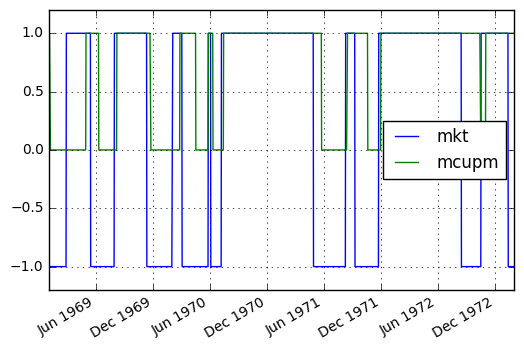

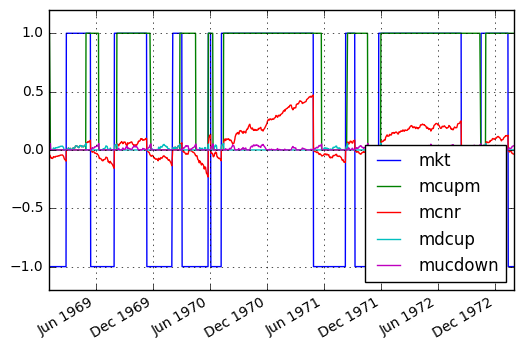

In [41]:
# Plot market cylce markers

#dfmc=dfmc_2025
#dfmc=dfmc_1010
dfmc=dfmc_55

st=dt.datetime(1969,1,1)
et=dt.datetime(1973,1,31)

#st=dt.datetime(1990,1,1)
#et=dt.datetime(1994,1,31)

#st=dt.datetime(2010,1,1)
#et=dt.datetime(2010,1,31)

#st=dt.datetime(2007,1,1)
#et=dt.datetime(2008,12,31)

dfmc.loc[st:et,['mkt','mcupm']].plot(grid=True)
plt.ylim(-1.2, 1.2)

dfmc.loc[st:et,['mkt','mcupm','mcnr','mdcup','mucdown']].plot(grid=True)
plt.ylim(-1.2, 1.2)

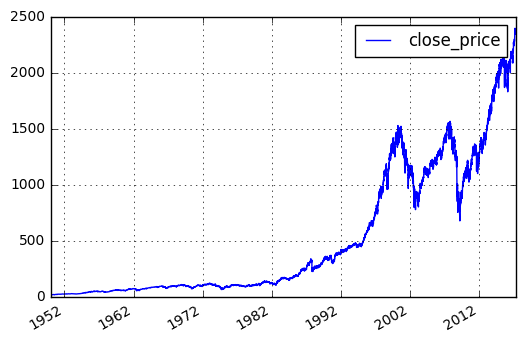

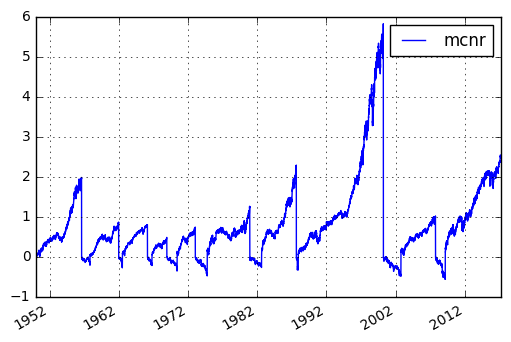

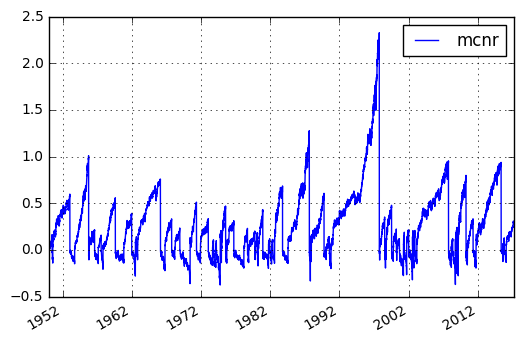

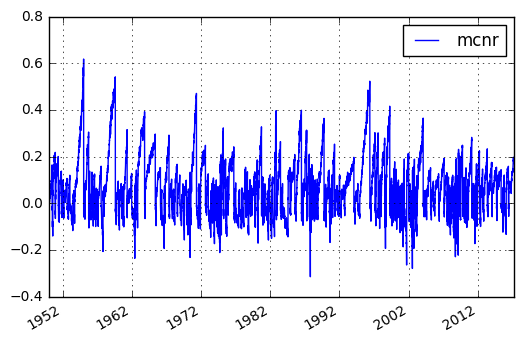

In [45]:
# Plot S&P

st=dataStartDate
et=today

#st=dt.datetime(2008,1,1)
#et=dt.datetime(2010,3,31)

#st=dt.datetime(1990,1,1)
#et=dt.datetime(2017,3,28)

dfsp.loc[st:et,['close_price']].plot(grid=True)
plt.ylim(0,2500)

dfmc_2025.loc[st:et,['mcnr']].plot(grid=True)

dfmc_1010.loc[st:et,['mcnr']].plot(grid=True)

dfmc_55.loc[st:et,['mcnr']].plot(grid=True)

In [133]:
# Strategy Trade CLF
%run algosciquant

dfmc=dfmc_2021

pvariable='mcupm'   #, p, ps, mcupm
print('start date =',test_st)
print('end date =',test_et)

start_strategy_trade=test_st
startyr=start_strategy_trade.year
today = dt.date.today()
end_strategy_trade=dt.datetime(today.year,today.month,today.day)
endyr=today.year
startyr=start_strategy_trade.year
yday = datetime.today().timetuple().tm_yday


print(ticker)
print(price_variable) 
print("...")

df1=dfmc.loc[start_strategy_trade:end_strategy_trade,[pvariable,'sdm','mkt']]
df1[pvariable+'_h1']=dfmc.loc[start_strategy_trade:end_strategy_trade,[pvariable]].shift(1)
df1[pvariable+'_h1'].loc[df1.index[0]]=0
df2=dfsp.loc[start_strategy_trade:end_strategy_trade,[price_variable]] 
dft=pd.concat([df1, df2], axis=1,join='inner')
dft = tradeReturns(dft,price_variable)
dft = strategyTrade(dft,price_variable,price_variable+'_R',pvariable+'_h1')

print(dft[[price_variable,price_variable+'_R',price_variable+'_SP','sdm',pvariable]].tail(5))


start date = 2000-01-01 00:00:00
end date = 2017-03-31 00:00:00
^GSPC
close_price
...
            close_price  close_price_R  close_price_SP  sdm  mcupm
2017-03-30  2368.060059       0.002935     2863.347073  0.0    1.0
2017-03-31  2362.719971      -0.002255     2856.890089  0.0    1.0
2017-04-03  2358.840088      -0.001642     2852.198717  0.0    1.0
2017-04-04  2360.159912       0.000560     2853.794586  0.0    1.0
2017-04-05  2354.230000      -0.002513     2846.624415  0.0    1.0


In [134]:
# BackTest
%run algosciquant

(dftsummary,dfreturns)=backTest(dft,price_variable,start_strategy_trade,end_strategy_trade)
print(dftsummary)
print("")
print(dfreturns[[ 'nyear',  'Rc','Ra','Rc_strat','Ra_strat']])

     start_date  start_close_price   end_date  end_close_price  \
2000 2000-01-03        1455.219971 2001-01-02      1283.270020   
2001 2001-01-02        1283.270020 2001-12-31      1148.079956   
2002 2002-01-02        1154.670044 2002-12-31       879.820007   
2003 2003-01-02         909.030029 2003-12-31      1111.920044   
2004 2004-01-02        1108.479980 2004-12-31      1211.920044   
2005 2005-01-03        1202.079956 2006-01-03      1268.800049   
2006 2006-01-03        1268.800049 2007-01-03      1416.599976   
2007 2007-01-03        1416.599976 2007-12-31      1468.359985   
2008 2008-01-02        1447.160034 2008-12-31       903.250000   
2009 2009-01-02         931.799988 2009-12-31      1115.099976   
2010 2010-01-04        1132.989990 2010-12-31      1257.640015   
2011 2011-01-03        1271.869995 2012-01-03      1277.060059   
2012 2012-01-03        1277.060059 2012-12-31      1426.189941   
2013 2013-01-02        1462.420044 2013-12-31      1848.359985   
2014 2014-

In [135]:
# Write strategy trade results to file
dft_write_filename="dft_2021_2000.csv"
dfts_write_filename = "dfts_2021_2000.csv"
dftr_write_filename = "dftr_2021_2000.csv"
dft.to_csv(dft_write_filename)
dftsummary.to_csv(dfts_write_filename)
dfreturns.to_csv(dftr_write_filename)

In [123]:
# Read from file
dft_read_filename = "dft_11_2000.csv"
dfts_read_filename = "dfts_11_2000.csv"
dftr_read_filename = "dftr_11_2000.csv"
dft_11= pd.read_csv(dft_read_filename,index_col=0,parse_dates=True)
dfts_11= pd.read_csv(dfts_read_filename,index_col=0,parse_dates=True)
dftr_11= pd.read_csv(dftr_read_filename,index_col=0,parse_dates=True)

In [104]:
# Returns Comparison Table

dft_2025.head(5)

,mcupm,sdm,mcupm_h1,close_price,close_price_R,close_price_SP
2000-01-03,1.0,0.0,0.0,1455.219971,0.000000,1455.219971
2000-01-04,1.0,0.0,1.0,1399.420044,-0.038345,1399.420044
2000-01-05,1.0,0.0,1.0,1402.109985,0.001922,1402.109985
2000-01-06,1.0,0.0,1.0,1403.449951,0.000956,1403.449951
2000-01-07,1.0,0.0,1.0,1441.469971,0.027090,1441.469971


2000-01-01 00:00:00 2017-03-31 00:00:00


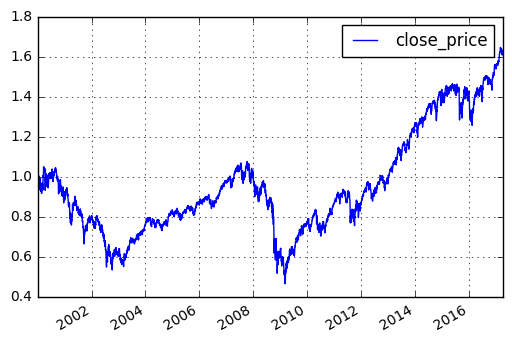

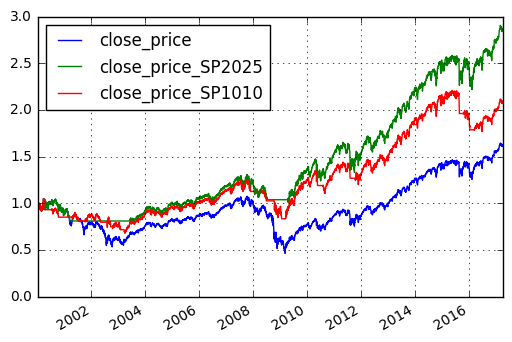

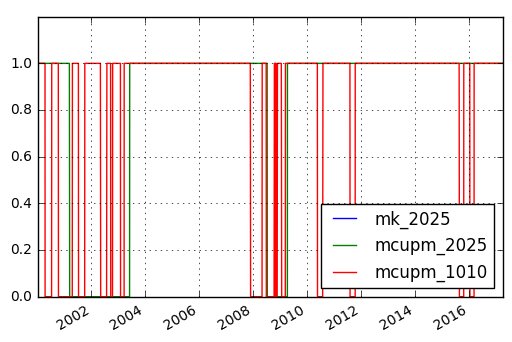

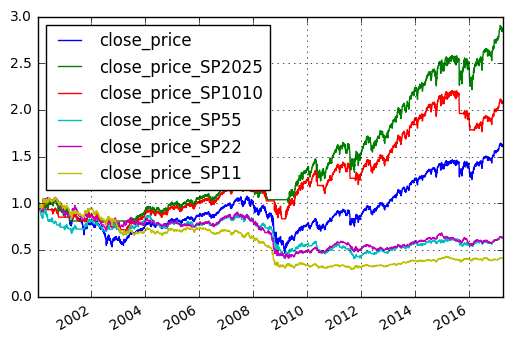

In [140]:
# Returns Graph (normalized to start date)

# read files and combine

# normalized trade data frame with start and end times
st = test_st
et = test_et

print(st,et)
#st = dt.datetime(2008,1,1)
#et = dt.datetime(2010,12,31)


dftn=dft_2025.loc[st:et,[price_variable]]/dft_2025.loc[dft_2025.index[0],price_variable]
dftn_i0=dftn.index[0]

dftn['mkt_2025']=dft_2025.loc[st:et,['mkt']]
dftn['mkt_1010']=dft_1010.loc[st:et,['mkt']]
dftn['mkt_55']=dft_55.loc[st:et,['mkt']]
dftn['mkt_22']=dft_11.loc[st:et,['mkt']]
dftn['mkt_11']=dft_11.loc[st:et,['mkt']]

dftn[price_variable]=dftn[price_variable]/dftn.loc[dftn_i0,price_variable]
dftn[price_variable+'_SP2025']=dft_2025.loc[st:et,price_variable+'_SP']/dft_2025.loc[dftn_i0,price_variable+'_SP']
dftn[price_variable+'_SP1010']=dft_1010.loc[st:et,[price_variable+'_SP']]/dft_1010.loc[dftn_i0,price_variable+'_SP']

#print(dftn[price_variable+'_SP2025'].tail(5))
#print(dft_2025.loc[dftn_i0,price_variable+'_SP'])


dftn[price_variable+'_SP55']=dft_55.loc[st:et,[price_variable+'_SP']]/dft_55.loc[dftn_i0,price_variable+'_SP']
dftn[price_variable+'_SP22']=dft_22.loc[st:et,[price_variable+'_SP']]/dft_22.loc[dftn_i0,price_variable+'_SP']
dftn[price_variable+'_SP11']=dft_11.loc[st:et,[price_variable+'_SP']]/dft_11.loc[dftn_i0,price_variable+'_SP']

dfmcupm=pd.DataFrame(index=dftn.index)

dftn['mcupm_2025']=dft_2025.loc[st:et,'mcupm']
dftn['mcupm_1010']=dft_1010.loc[st:et,'mcupm']
dftn['mcupm_55']=dft_55.loc[st:et,'mcupm']
dftn['mcupm_22']=dft_22.loc[st:et,'mcupm']
dftn['mcupm_11']=dft_22.loc[st:et,'mcupm']

dftn['mcupm_2025_h1']=dft_2025.loc[st:et,'mcupm_h1']
dftn['mcupm_1010_h1']=dft_1010.loc[st:et,'mcupm_h1']
dftn['mcupm_55_h1']=dft_55.loc[st:et,'mcupm_h1']
dftn['mcupm_22_h1']=dft_22.loc[st:et,'mcupm_h1']
dftn['mcupm_11_h1']=dft_22.loc[st:et,'mcupm_h1']

# plot start and end times

pst=st
pet=et

#pst = dt.datetime(2008,1,1)
#pet = dt.datetime(2009,6,1)


dftn.loc[pst:pet,[price_variable]].plot(grid=True)

dftn.loc[pst:pet,[price_variable,price_variable+'_SP2025',price_variable+'_SP1010']].plot(grid=True)


#dfmcupm.loc[pst:pet,['mcupm_2025']].plot(grid=True)
dftn.loc[pst:pet,['mk_2025','mcupm_2025','mcupm_1010']].plot(grid=True)
#dftn.loc[pst:pet,['mcupm_2025','mcupm_1010','mcupm_55']].plot(grid=True)
#dftn.loc[pst:pet,['mcupm_2025','mcupm_1010','mcupm_55','mcupm_11']].plot(grid=True)

plt.ylim(0,1.2)

dftn.loc[pst:pet,[price_variable,price_variable+'_SP2025',price_variable+'_SP1010',price_variable+'_SP55',price_variable+'_SP22',price_variable+'_SP11']].plot(grid=True)


(0, 1.8)

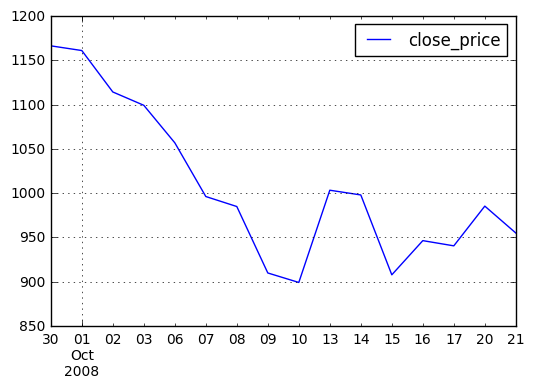

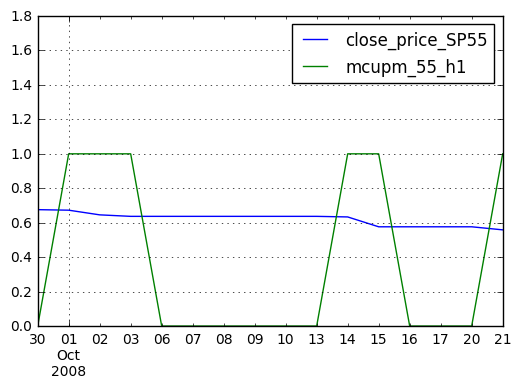

In [141]:
# How does it work?

dft_read_filename = "dft_55.csv"
dft = pd.read_csv(dft_read_filename,index_col=0,parse_dates=True)

dfmc_read_filename="dfmc_55.csv"
dfmc = pd.read_csv(dfmc_read_filename,index_col=0,parse_dates=True)


#up cycle
sp=dt.datetime(2010,12,1)
et=dt.datetime(2011,12,1)

#dfsp.loc[st:et,price_variable].plot(grid=True)

# Example 2, down cycle
st=dt.datetime(2008,8,1)
et=dt.datetime(2008,12,1)

st=dt.datetime(2008,9,30)
et=dt.datetime(2008,10,21)

dfsp.loc[st:et,[price_variable]].plot(grid=True)

dftn.loc[st:et,[price_variable+'_SP55','mcupm_55_h1']].plot(grid=True)
plt.ylim(0,1.8)




In [656]:
#st = dt.datetime(2008,9,16)
#et = dt.datetime(2008,10,14)

#st = dt.datetime(2016,7,1)
#et = dt.datetime(2016,8,1)

st = dt.datetime(2017,1,1)
et = dt.datetime(2017,1,10)

dft.loc[st:et,[price_variable,price_variable+'_R','t','p','p_np1',price_variable+'_SP']]

,close_price,close_price_R,t,p,p_np1,close_price_SP
2017-01-03,2257.830078,0.008487,1.0,-1.0,1.0,2717.519050
2017-01-04,2270.750000,0.005722,1.0,1.0,1.0,2733.069438
2017-01-05,2269.000000,-0.000771,1.0,1.0,1.0,2730.963142
2017-01-06,2276.979980,0.003517,1.0,1.0,-1.0,2740.567828
2017-01-09,2268.899902,-0.003549,1.0,-1.0,1.0,2740.567828
2017-01-10,2268.899902,0.000000,1.0,1.0,1.0,2740.567828


In [398]:
# http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html


dotf = "dt.dot"
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open(dotf, 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        

# the following command will export "dt.dot" file
visualize_tree(clf, X.columns)

# run the following command in the directory contaning "dt.dot" file
# > dot -Tpng dt.dot -o dt.png
# > open dt.png

## References

- Find stocks, [Kiplinger 8 Stocks](http://www.kiplinger.com/slideshow/investing/T052-S003-8-stocks-to-buy-now-for-2017/index.html)

- Kiplingers, "10 Great Stocks for the Next 10 Years", December 2016,   PNRA, ADBE, DHR, FBHS, IDXX, LGF

- Kiplingers, "8 Stocks to buy for now", Jan 2017, GOOG, CMD, AAPL, MEDP

- Kiplingers, "My Top Stock Picks for 2017," Jan 2017, AMZN, CVU, SBUX, CRM

- Other stocks, BRK.B, ^GSPC, KO

- Stanford ML CS229 Trend Stock Prediction,  [Stanford CS229 ML Stock Prediction](http://cs229.stanford.edu/proj2013/DaiZhang-MachineLearningInStockPriceTrendForecsting.pdf) ... **ML Features** PE ratio, PX volume, PX ebitda, current enterprise value, 2-day net price change, 10-day volatility, 50-day moving average, 10-day moving average, quick ratio, alpha overridable, alpha for beta pm, beta raw overridable, risk premium, IS EPS, and corresponding S&P 500 index
- CS229 Stock Prediction Feature Selection, ...  http://cs229.stanford.edu/proj2014/Xinjie%20Di,%20Stock%20Trend%20Prediction%20with%20Technical%20Indicators%20using%20SVM.pdf  ... 

- Stanford ML CS229 Text/Article Stock Prediction, [CS229 Bryce Taylor](http://cs229.stanford.edu/proj2013/Taylor-Applying%20Machine%20Learning%20to%20Stock%20Market%20Trading.pdf)
    
- Stock correlations, [Asset Correlations](https://www.portfoliovisualizer.com/asset-correlations)
    
- Example noteboek, [Python Clustering](http://brandonrose.org/clustering)

- Where to get financial data, Quroa - Intrinio, <https://www.quora.com/What-are-some-cheaper-alternatives-to-Bloomberg-data-terminal>

- Intrino, <https://intrinio.com> ... <http://blog.intrinio.com/intrinio-financial-data-in-r-and-rstudio/>  ... API  <http://blog.intrinio.com/stock-api-developers/> ...  <http://docs.intrinio.com>  ... Python Github https://github.com/nhedlund/intrinio .... http://docs.intrinio.com/tags/intrinio-public#data-point .... Converasation with Andrew Carpenter, Intrinio.com ... What I used R for, which I bet you can do better in Python, is to pull in historical prices and then a vector of historical explainatory variables on the same time period. I automated it, and filled forward the quarterly data to match the daily data. Which is the standard in the industry, I learn from my professors. So that gives you a nice clean data frame with as many explainatory variables as you want- valuation metrics, earnings, economic indicators like SPY and VIX. acarpenter@intrinio.com 727-331-3416. ... from the API page  <http://blog.intrinio.com/stock-api-developers/>  good info plus make sure to watch the video. Entire price history using "price" endpoint "https://inntrinio.com/prices?ticker=AAPL" includes 13 data points open, close, adj_high, ... volume  ... use datapoint function to pull in specific data points "https://inntrinio.com/datapoint?ticker=AAPL&item=close_price" ... use the "historical_data" endpoint to pull in time-series "https://inntrinio.com/historical_data?ticker=AAPL&item=pricetoearnings&start_date=2014-01-01&end_date_2015-01-01" ... you can also add in a frequency as "&frequency=yearly"   (yearly, quarterly, monthly, weekly, daily) ... or just the start_date ... **Historical Data Features**  <http://docs.intrinio.com/tags/intrinio-public#historical-data> ... **Modeling financial data in R** ... http://blog.intrinio.com/modeling-financial-data-in-r-with-intrinio/